In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

REACT_SYSTEM_PROMPT = os.getenv("REACT_SYSTEM_PROMPT")
GROQ_API_TOKEN = os.getenv("GROQ_API_KEY")
COMPILER_URL = os.getenv("COMPILER_URL")


In [39]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [40]:
import nest_asyncio
nest_asyncio.apply()


In [41]:
from pydantic import Field
from typing import TypedDict

class ExtractCode(TypedDict):
    '''
    Formatted Output for llm
    Attributes:
    code (str): code generated by the llm
    language (str): language of the code generated by the llm 
    '''
    code: str = Field(
    ...,
    description="Solution of the code",
    )
    language: str | None = Field(
    ..., description="Programming language of the code"
    )

In [42]:
import requests
from langchain_groq import ChatGroq
from langchain_core.tools import tool

model = ChatGroq(model = "meta-llama/llama-4-maverick-17b-128e-instruct")

@tool
def compiler(code: str, language:str) -> str:
    '''"
    Call everytime to send code to compiler/interpreter to get output for the code
    
    '''
    response = requests.post(COMPILER_URL,
                            json={
                                "code": code,
                                "language": language,
                            },
                        )
    result = response.json()
    if response.status_code == 200:
        output = result.get("output")
        return output
    else:
        output = result
        return output

tools = [compiler]
model.bind_tools(tools)

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001363DA267B0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001363DA90950>, model_name='meta-llama/llama-4-maverick-17b-128e-instruct', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'compiler', 'description': '"\nCall everytime to send code to compiler/interpreter to get output for the code', 'parameters': {'properties': {'code': {'type': 'string'}, 'language': {'type': 'string'}}, 'required': ['code', 'language'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [43]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}


# Define our tool node
def tool_node(state: State):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: State,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        REACT_SYSTEM_PROMPT
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

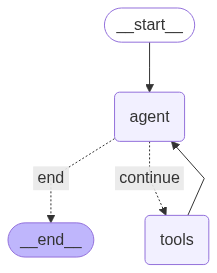

In [44]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [49]:
from langgraph.errors import GraphRecursionError
from langgraph.prebuilt import create_react_agent

max_iterations = 10
recursion_limit = 2 * max_iterations + 1
agent = create_react_agent(
    model="groq:llama3-8b-8192", tools=[compiler]
)

try:
    inputs = {
        "messages": [
            (
                "user",
                "Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target. Assume exactly one solution exists. Write the function in Python.",
            )
        ]
    }
    print_stream(agent.stream(inputs, stream_mode="values"))
except GraphRecursionError:
    print("Agent stopped due to max iterations.")

================================ Human Message =================================

Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target. Assume exactly one solution exists. Write the function in Python.
================================== Ai Message ==================================
Tool Calls:
  compiler (call_17tv)
 Call ID: call_17tv
  Args:
    code: def two_sum(nums, target):
    for i in range(len(nums)):
        for j in range(i+1, len(nums)):
            if nums[i] + nums[j] == target:
                return [i, j]
    return []
    language: python
================================= Tool Message =================================
Name: compiler


================================== Ai Message ==================================

[2, 7]
